# 1. Importing libraries

In [380]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import urllib.request
import urllib
import tarfile
from natsort import natsorted 
import cv2

# 2. Dataset

## 2.1. Download

In [381]:
# def download_and_extract_oxford_pet_dataset(destination_folder):
#     """
#     Baixa e extrai o Oxford-IIIT Pet Dataset (imagens e anotações).
    
#     :param destination_folder: Caminho do diretório onde os arquivos serão salvos e extraídos.
#     """
#     # URLs dos arquivos
#     urls = {
#         "images": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
#         "annotations": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
#     }
    
#     # Criar a pasta de destino, se não existir
#     os.makedirs(destination_folder, exist_ok=True)
    
#     for key, url in urls.items():
#         print(f"Baixando {key}...")
#         file_name = os.path.join(destination_folder, url.split("/")[-1])
        
#         # Fazer o download do arquivo
#         urllib.request.urlretrieve(url, file_name)
#         print(f"Download concluído: {file_name}")
        
#         # Extrair o arquivo tar.gz
#         print(f"Extraindo {key}...")
#         with tarfile.open(file_name, "r:gz") as tar:
#             tar.extractall(path=destination_folder)
#         print(f"Extração concluída para {key}.\n")

#         # Remover o arquivo compactado para economizar espaço
#         os.remove(file_name)
#         print(f"Arquivo compactado {file_name} removido.")

# # Exemplo de uso
# destination_folder = "./oxford_pet_dataset"  # Caminho onde o dataset será salvo
# download_and_extract_oxford_pet_dataset(destination_folder)

## 2.2. Definition

Resizing original images and segmented images to 300x300 and transforming into NumpyArray:

In [382]:
def load_and_resize_images(folder_path, target_size=(300, 300), mode=None):
    """
    Carrega imagens de uma pasta, redimensiona para um tamanho fixo e transforma em um array NumPy.
    
    :param folder_path: Caminho para a pasta contendo as imagens.
    :param target_size: Tamanho fixo (largura, altura) para redimensionar as imagens.
    :param mode: 0 se imagens, 1 se trimaps
    :return: Array NumPy com todas as imagens redimensionadas.
    """

    file_names = natsorted(os.listdir(folder_path))

    image_arrays = []
    for filename in file_names:
        file_path = os.path.join(folder_path, filename)
        try:
            if mode == 0:
                with Image.open(file_path) as img:
                    img_resized = img.resize(target_size)  # redimensiona para 300x300
                    img_array = np.array(img_resized)     # converte para array NumPy
                    
                    if len(img_array.shape) == 2:
                        img_array = np.stack([img_array] * 3, axis=-1)
                    
                    image_arrays.append(img_array)
            
            elif mode ==1:
                with Image.open(file_path) as img:
                    img = img.convert("L")  
                    
                    img_resized = img.resize(target_size, resample=Image.NEAREST)
                    
                    trimap_array = np.array(img_resized)
                    
                    image_arrays.append(trimap_array)
            else:
                print(f"Mode not suported.")

        except Exception as e:
            print(f"Erro ao processar {filename}: {e}")
    
    images_array = np.stack(image_arrays, axis=0)
    return images_array

In [383]:
folder_path = "./oxford_pet_dataset/images/"
data = load_and_resize_images(folder_path, mode=0)

folder_path = "./oxford_pet_dataset/annotations/trimaps/"
data_tri_segmented = load_and_resize_images(folder_path, mode=1)

print(f"Shape do array data gerado: {data.shape}")
print(f"Shape do array segmented gerado: {data_tri_segmented.shape}")

Shape do array data gerado: (26, 300, 300, 3)
Shape do array segmented gerado: (26, 300, 300)


Viewing sample images and segmentations:

In [384]:
def visualize_segmented_image(data, data_segmented, num_images):
    """
    Exibe uma imagem e sua segmentação lado a lado.
    
    :param data: Array de imagens do Oxford-IIIT Pet Dataset.
    :param data_semented: Array de segmentações.
    :param num_images: número de imagens a serem exibidas
    """

    for i in range(num_images):
        plt.figure(figsize=(12, 6))
        
        # imagem original
        plt.subplot(1, 2, 1)
        plt.imshow(data[i])
        plt.title("Imagem Original")
        plt.axis("off")
        
        # segmentada
        plt.subplot(1, 2, 2)
        plt.imshow(data_segmented[i], cmap='gray')
        plt.title("Segmentação (Trimap)")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

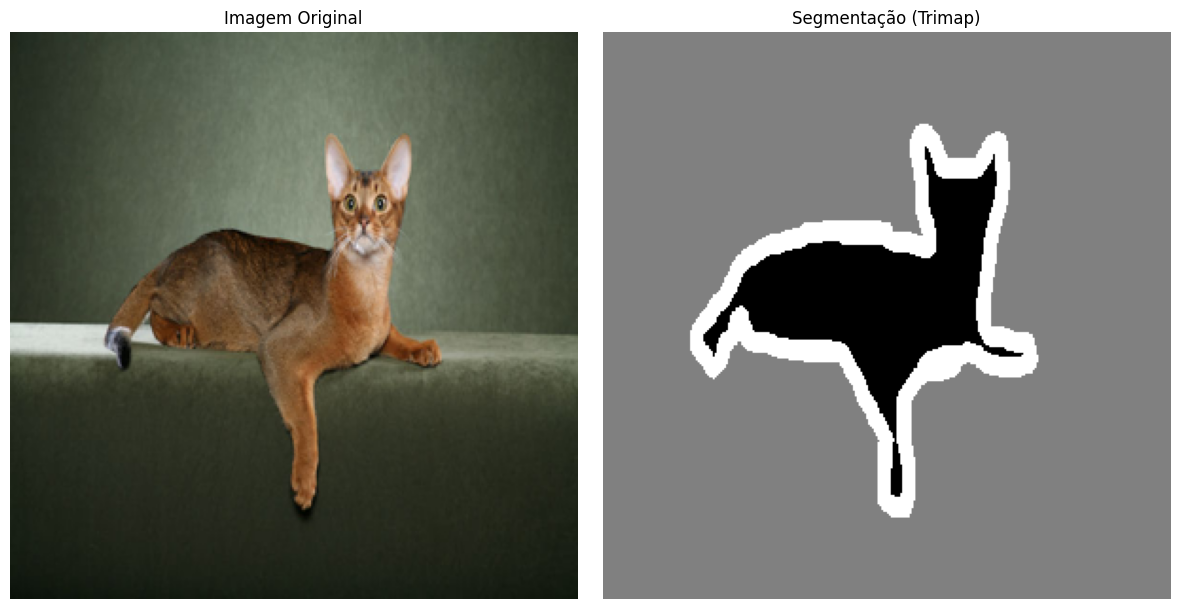

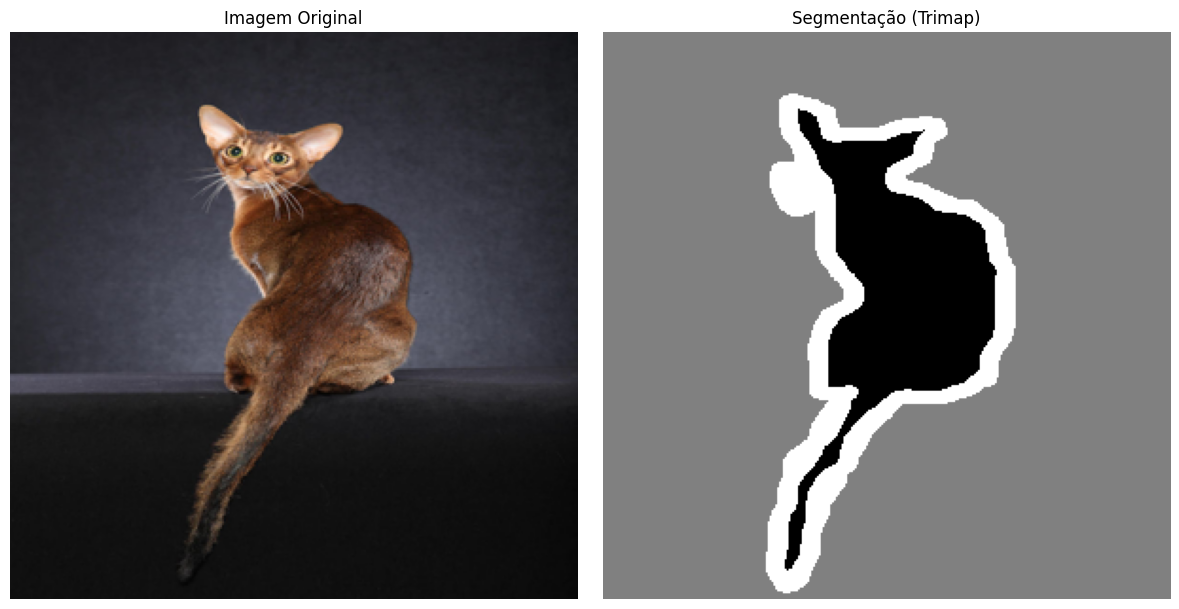

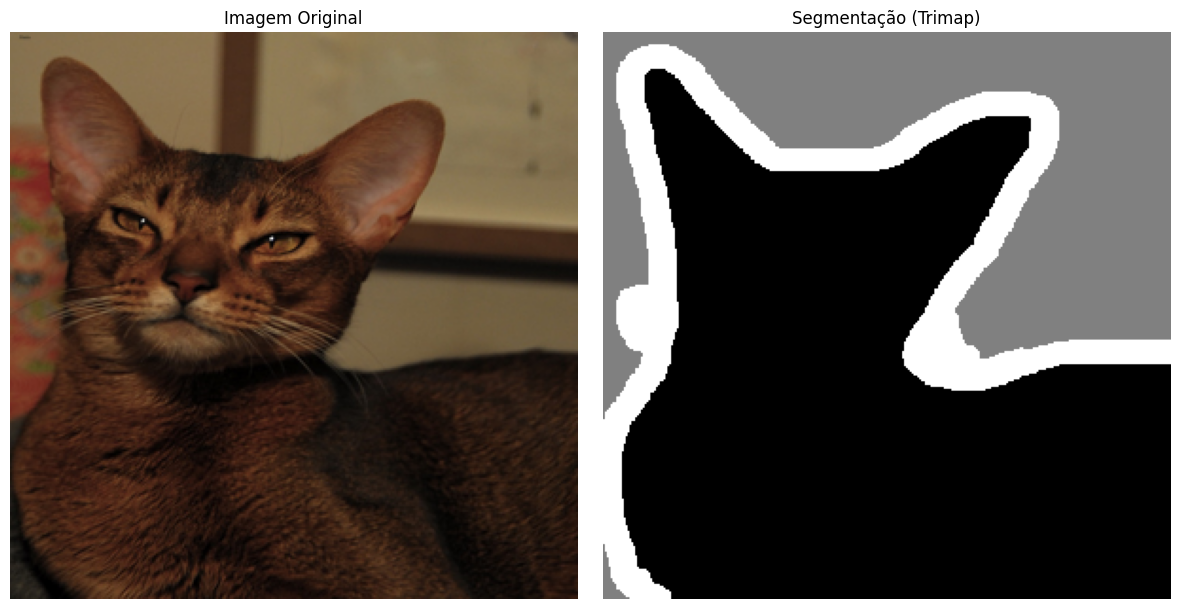

In [385]:
visualize_segmented_image(data,data_tri_segmented, num_images=3)

Combinando segmentação para deixar apenas objeto (gato) e fundo:

In [386]:
def combine_classes(data_seg):
    """
    Combina as classes 1 e 2 em uma única classe (1) e deixa o fundo como 0.
    
    :param annotation_path: Caminho para o arquivo de segmentação (trimap).
    :return: Array NumPy com a segmentação ajustada.
    """
    binary_annotation = []
    
    for img_seg in data_seg:
        binary_annotation.append(np.where(img_seg == 2, 0, 1))
    
    images_array = np.stack(binary_annotation, axis=0)

    return images_array


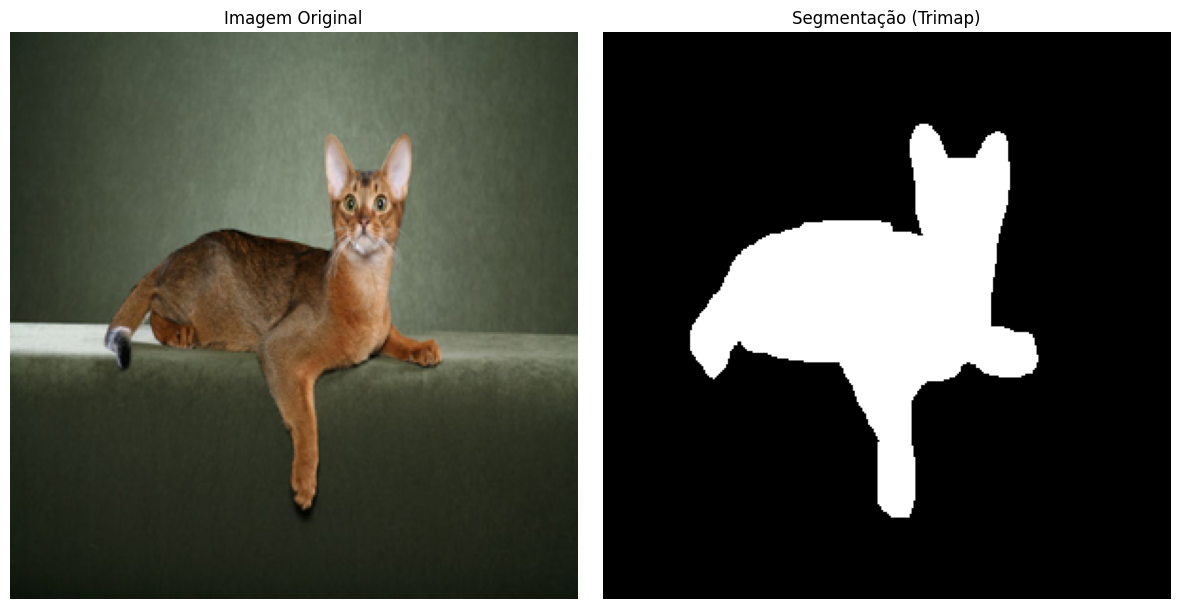

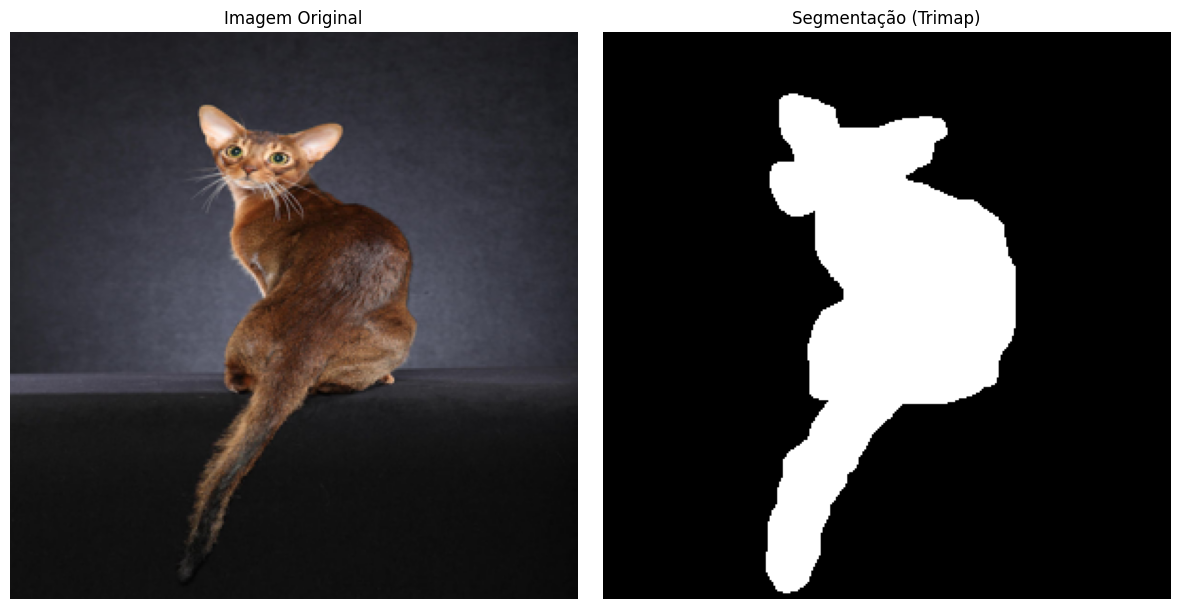

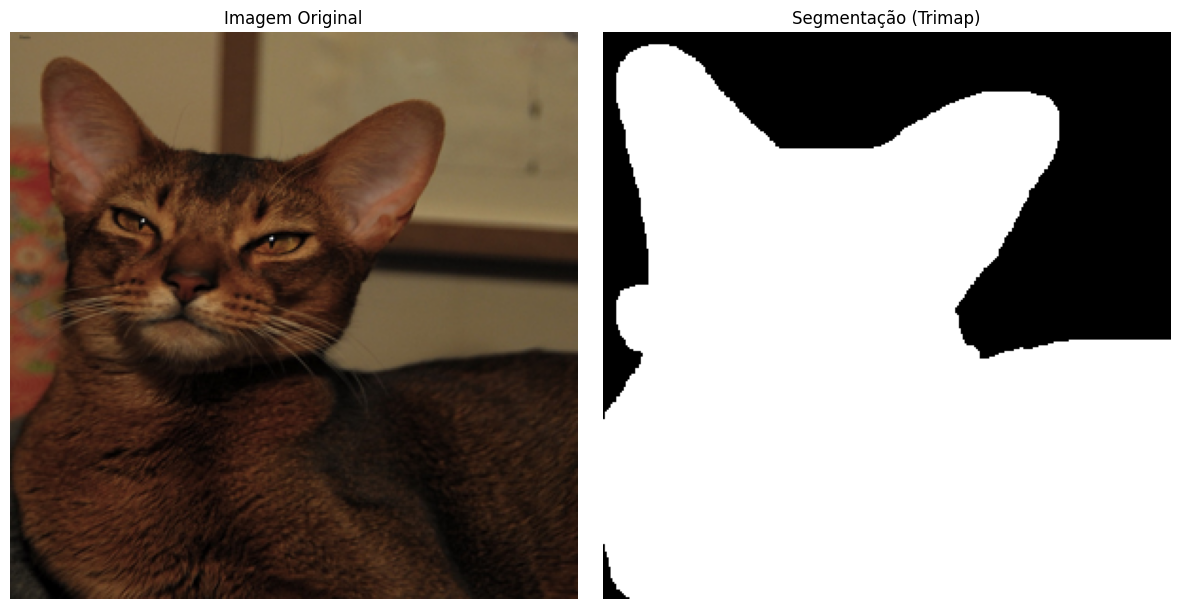

In [387]:
data_segmented = combine_classes(data_tri_segmented)

visualize_segmented_image(data,data_segmented,3)

# 3. Preprocessing

## 3.1. Transforming images into gray scale

In [388]:
def gray_transforming(images):
    """
    Tranforma base de imagens para tom de cinza.

    :param data: Array de imagens a serem preprocessadas.
    """
    
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

    return gray_images

def visualize_gray_image(data, num_images, title):
    """
    Exibe uma imagem e sua segmentação lado a lado.
    
    :param data: Array de imagens do Oxford-IIIT Pet Dataset.
    :param data_semented: Array de segmentações.
    :param num_images: número de imagens a serem exibidas
    """

    plt.figure(figsize=(15, 6))
    
    for i in range(num_images):    
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(data[i], cmap='gray')
        plt.title(title)
        plt.axis("off")

    plt.show()
        

In [389]:
data_gray = gray_transforming(data) 

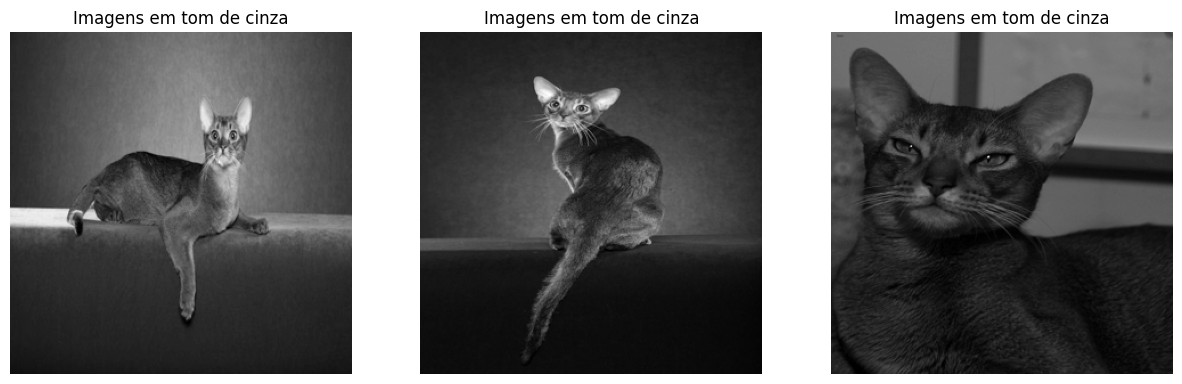

In [390]:
visualize_gray_image(data_gray, num_images=3, title="Imagens em tom de cinza")

## 3.2. Changing the color system

In [391]:
def color_system_change(images):
    """
    Transforma base de imagens para sistema de cor YUV.

    :param data: Array de imagens a serem preprocessadas.
    """

    system_change = []
    for img in images:

        # converte para YUV
        yuv_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

        edges = yuv_image
        # # extrai apenas o canal de luminância (Y)
        # luminance = yuv_image[:, :, 0]

        # # aplica um detector de bordas, como Canny
        # edges = cv2.Canny(luminance, 100, 200)
        
        system_change.append(edges)

    system_change = np.stack(system_change, axis=0)

    return system_change

In [392]:
data_color_system_change = color_system_change(data) 
data_color_system_change_gray = gray_transforming(data_color_system_change)

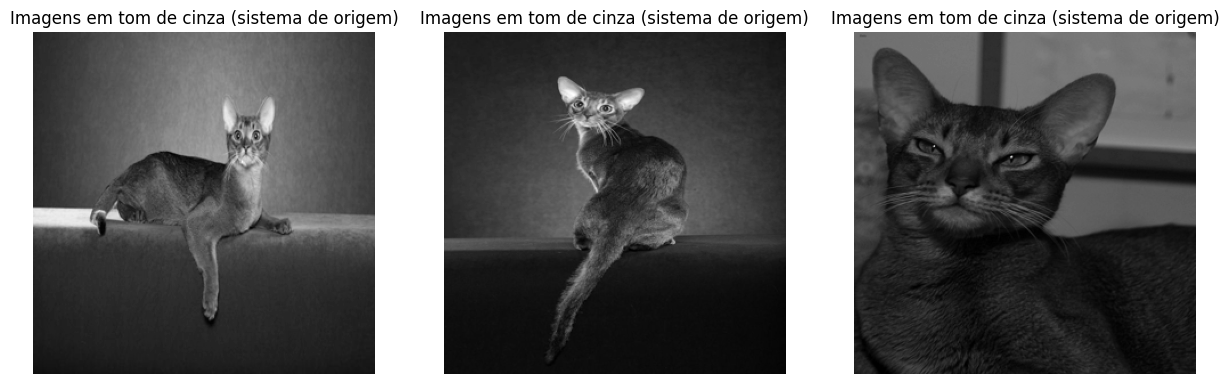

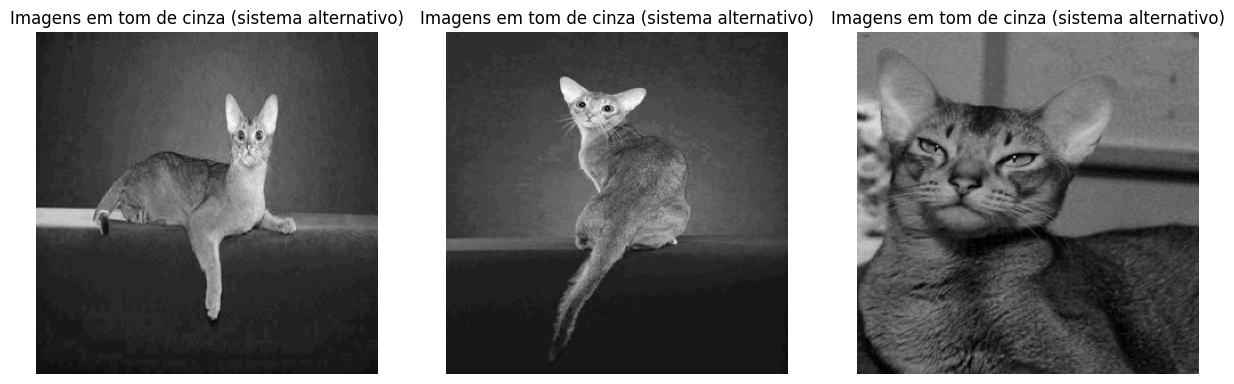

In [393]:
visualize_gray_image(data_gray, title="Imagens em tom de cinza (sistema de origem)", num_images=3)
visualize_gray_image(data_color_system_change_gray, title="Imagens em tom de cinza (sistema alternativo)", num_images=3)

# 4. Developing strategy for image segmentation

## 4.1. Filtering + Tresholding + Erosation + Dilatation

Parâmetros:

1- Kernel para filtro passa alta \
2- Corte para binarizar \
3- Elemento estruturante para erosão \
4- Número de iterações na erosão \
5- Elemento estruturante para dilatação \
6- Número de iterações na dilatação 


In [401]:
def viewing(img, title):
    plt.figure(figsize=(6, 6))    
    plt.imshow(img, cmap='gray')        
    plt.title(title)
    plt.axis("off")
    plt.show()


def segmentation_strategy_one(data, filter_kernel=None, corte=None, erosion_kernel=None, dilatation_kernel = None, num_it_erosion=None, num_it_dilatation=None):

    data_segmented_strategy_one = []

    for i, image in enumerate(data):
        if i == 0:
            viewing(image, "Imagem original")

        ### applying high-pass filter ###
        if filter_kernel is None:
            filter_kernel = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])

        img = cv2.filter2D(image, -1, filter_kernel)
        
        if i == 0:
            viewing(img, "Imagem filtrada passa alta")

        ### applying treshold to binarize the image ###
        if corte is None:
            mean = np.mean(img)
            std = np.std(img)

            corte = mean + 2*std

        _, img = cv2.threshold(img, corte, 255, cv2.THRESH_BINARY)

        if i == 0:
            viewing(img, "Imagem binarizada")

        # ### applying erosion before dilatation ###
        # if erosion_kernel is None:
        #     #erosion_kernel = np.ones((5, 5), np.uint8)
        #     erosion_kernel = np.array([[0,1,1,0], [1,1,1,1], [0,1,1,0]], np.uint8)
        
        # if num_it_erosion is None:
        #     num_it_erosion = 1
            
        # img = cv2.erode(img, erosion_kernel, iterations=num_it_erosion)
        
        if i == 0:
            viewing(img, "Imagem erosada")

        ### using operation to whiten images with enough white pixels in the vicinity ###
        if dilatation_kernel is None:
            dilatation_kernel = np.ones((11, 11), np.uint8)
        
        if num_it_dilatation is None:
            num_it_dilatation = 1
            
        img = cv2.dilate(img, dilatation_kernel, iterations=num_it_dilatation)
        
        if i == 0:
            viewing(img, "Imagem dilatada")

        # adding into an array
        data_segmented_strategy_one.append(img)

    data_segmented_strategy_one = np.stack(data_segmented_strategy_one, axis=0)
    
    return data_segmented_strategy_one

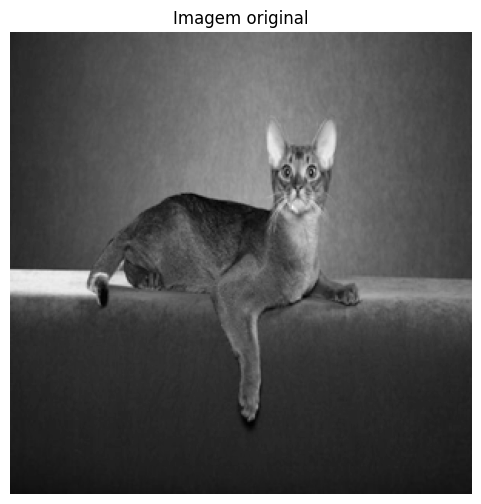

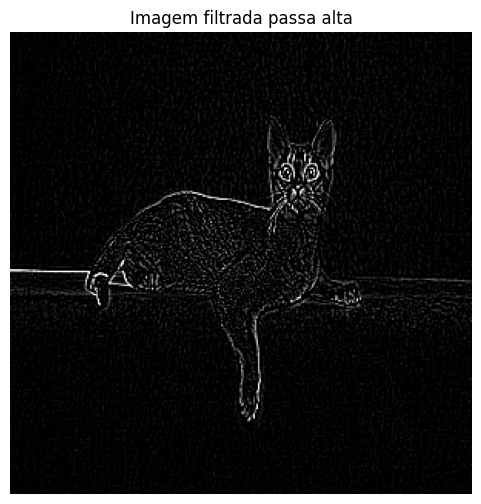

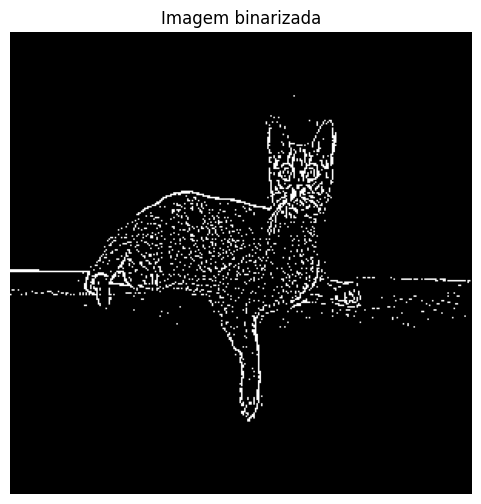

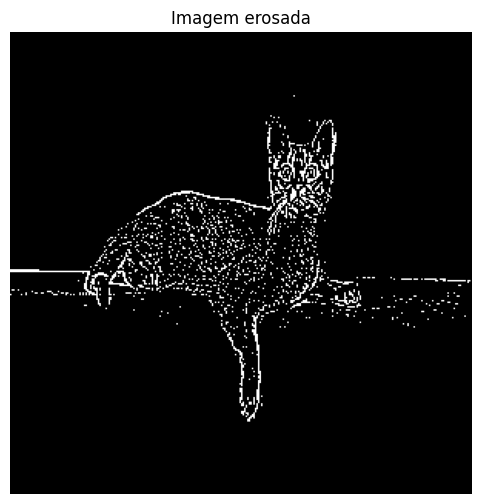

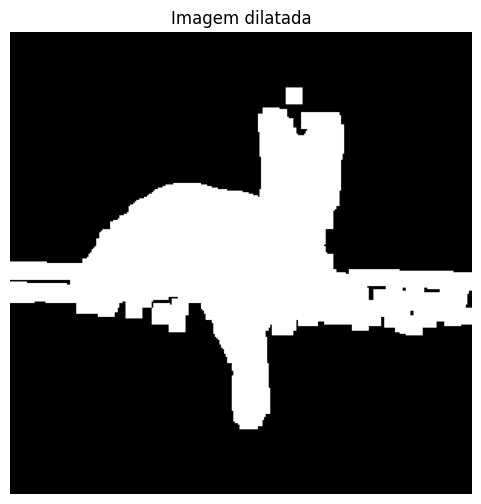

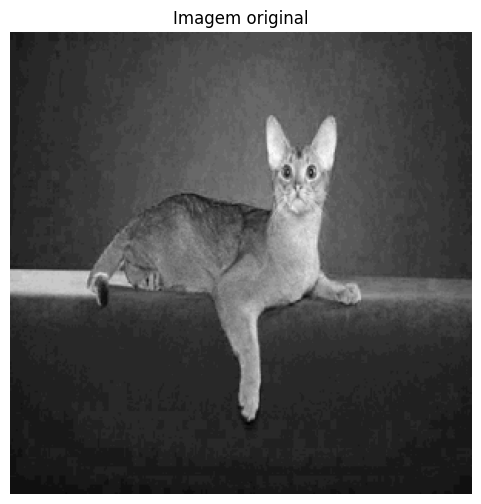

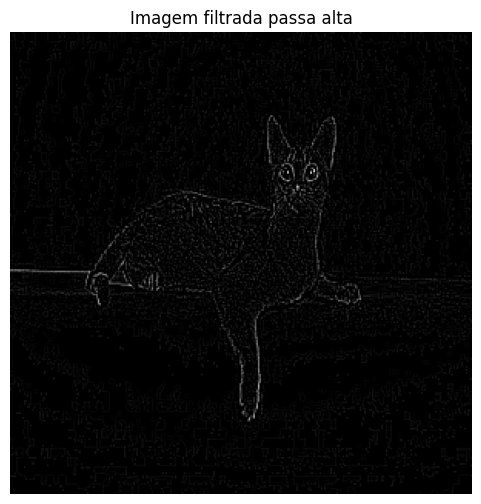

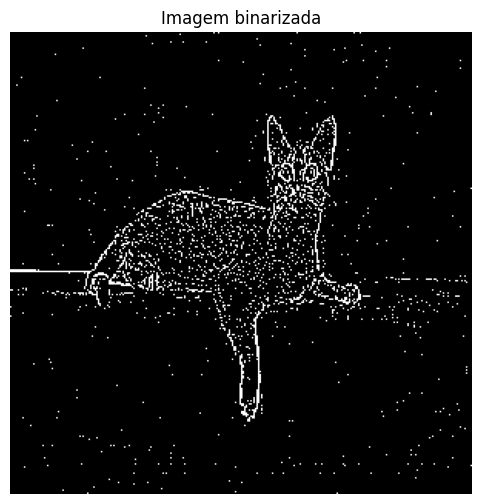

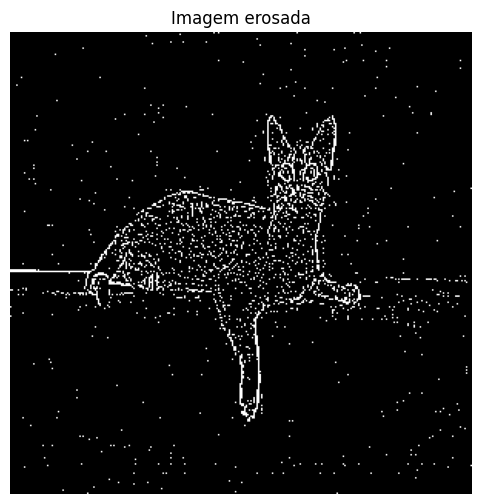

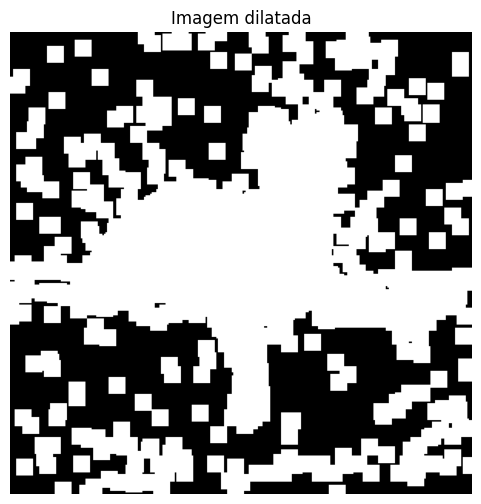

In [402]:
data_segmented_strategy_one = segmentation_strategy_one(data_gray)
data_system_change_segmented_strategy_one = segmentation_strategy_one(data_color_system_change_gray)

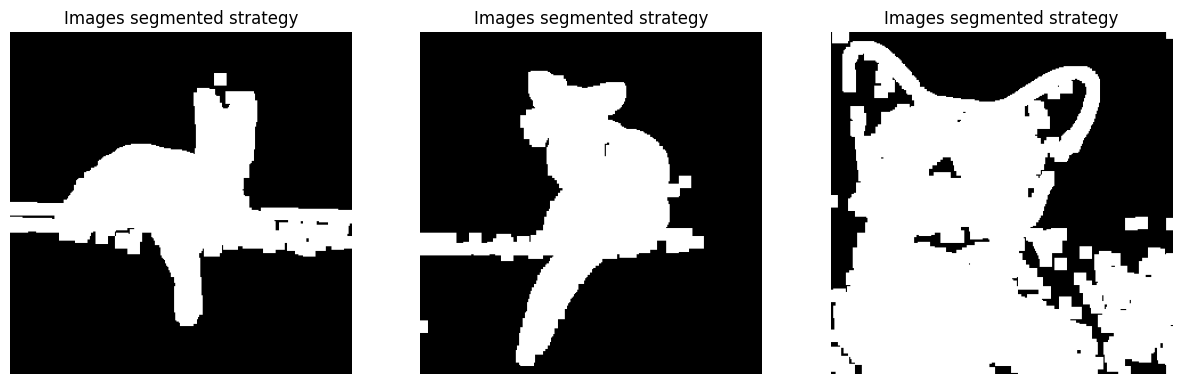

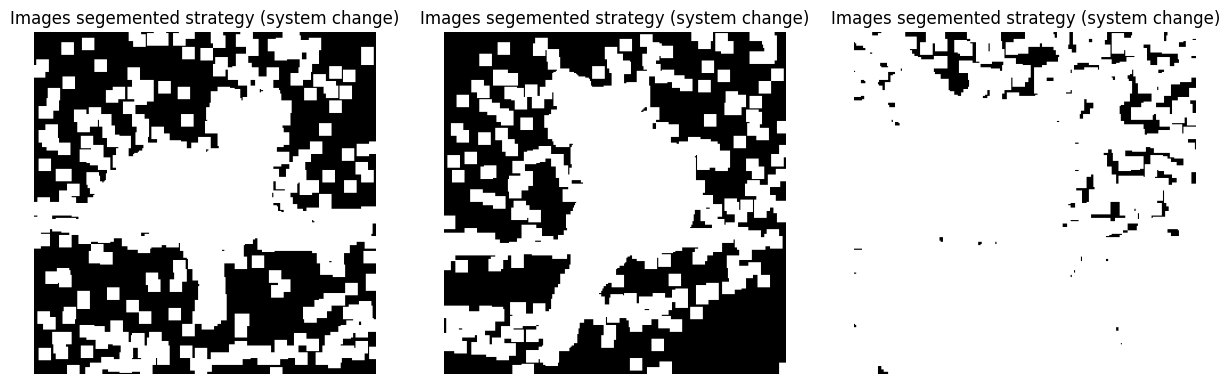

In [403]:
visualize_gray_image(data_segmented_strategy_one, num_images=3, title="Images segmented strategy")
visualize_gray_image(data_system_change_segmented_strategy_one, num_images=3, title="Images segemented strategy (system change)")

Viewing accuracy:

In [404]:
def accuracy(data_segmented, data_segmented_strategy):
    """
    Calcula a acurácia da segmentação original comparada com a estratégia desenvolvida
    """

    data_segmented_strategy = data_segmented_strategy / 255
    data_segmented_strategy = data_segmented_strategy.astype(int)

    # accuracy per image
    accuracy_per_image = []

    for i in range(len(data_segmented)):
        
        accuracy_image = np.sum(data_segmented[i] == data_segmented_strategy[i]) / (300*300)
        accuracy_image = accuracy_image * 100
        accuracy_per_image.append(accuracy_image)

    accuracy_per_image = np.array(accuracy_per_image)

    # accuracy total
    accuracy = np.sum(data_segmented == data_segmented_strategy) / (300*300*26)
    accuracy = accuracy * 100
    
    return accuracy_per_image, accuracy


In [405]:
accuracy_strategy_one_per_image, accuracy_strategy_one_total = accuracy(data_segmented, data_segmented_strategy_one)
print(f"Accuracy segmentation gray data with strategy one: {accuracy_strategy_one_total:.2f} %")

print(accuracy_strategy_one_per_image)

Accuracy segmentation gray data with strategy one: 77.80 %
[92.48       95.03555556 86.67333333 77.56888889 97.17333333 88.57111111
 28.60777778 96.89888889 97.21       35.07111111 95.07111111 96.47666667
 71.11777778 71.20555556 97.53333333 88.18222222 65.45333333 68.78777778
 42.12555556 70.65555556 84.52666667 66.22       75.51666667 94.52888889
 92.28333333 47.80555556]


In [406]:
accuracy_system_change_strategy_one_per_image, accuracy_system_change_strategy_one_total = accuracy(data_segmented, data_system_change_segmented_strategy_one)
print(f"Accuracy segmentation gray data system color transformed with strategy one: {accuracy_system_change_strategy_one_total:.2f} %")

print(accuracy_system_change_strategy_one_per_image)

Accuracy segmentation gray data system color transformed with strategy one: 64.22 %
[64.26666667 68.79888889 77.41888889 58.7        89.40555556 73.03333333
 29.06333333 95.1        76.22777778 19.97666667 93.70222222 76.52444444
 60.87888889 34.30777778 66.13444444 38.54333333 57.54222222 77.32111111
 37.31111111 67.86111111 42.46555556 67.58444444 46.49111111 94.82222222
 77.75666667 78.46222222]


Variando parâmetros:

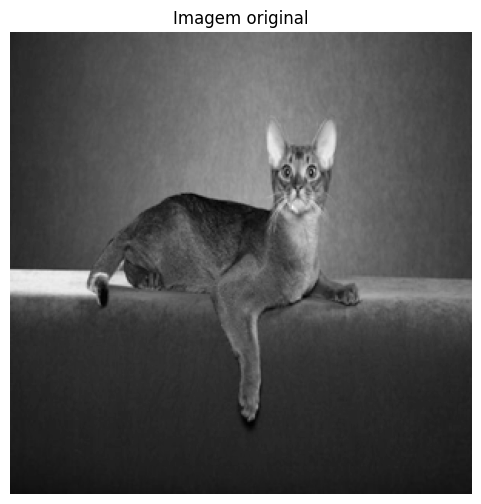

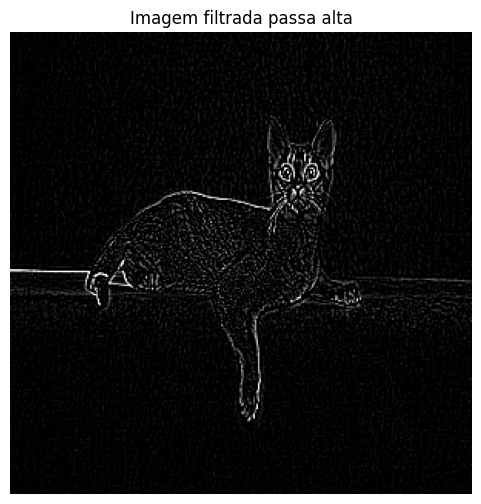

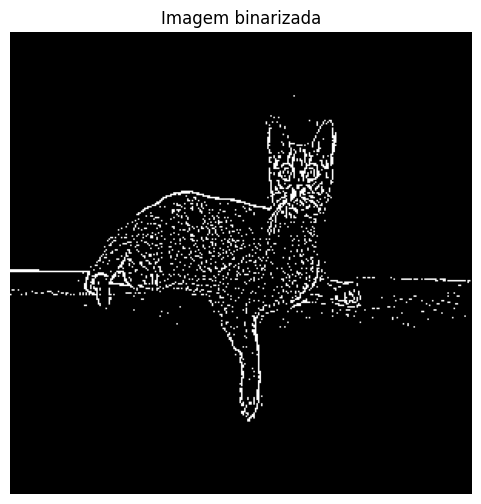

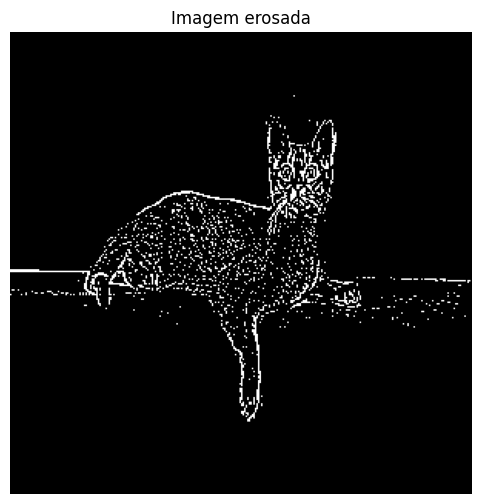

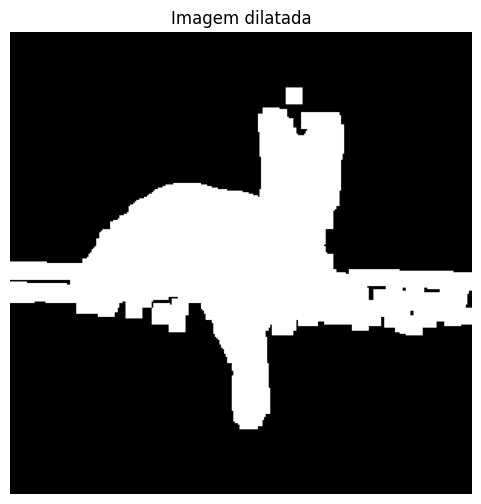

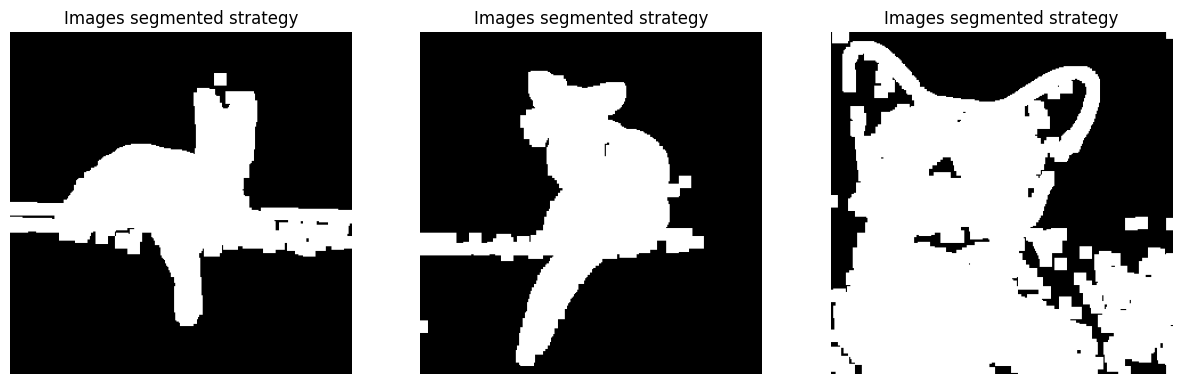

Accuracy segmentation gray data with strategy one: 77.80 %
[92.48       95.03555556 86.67333333 77.56888889 97.17333333 88.57111111
 28.60777778 96.89888889 97.21       35.07111111 95.07111111 96.47666667
 71.11777778 71.20555556 97.53333333 88.18222222 65.45333333 68.78777778
 42.12555556 70.65555556 84.52666667 66.22       75.51666667 94.52888889
 92.28333333 47.80555556]


In [410]:
kernel = np.array([[-1, -1, -1], [-1,  8, -1], [-1, -1, -1]])
elemento_estruturante = np.ones((3, 3), np.uint8)
iteracoes = 5

# calculando e visualizando
data_segmented_strategy_one = segmentation_strategy_one(data_gray, filter_kernel=kernel, dilatation_kernel=elemento_estruturante, num_it_dilatation=iteracoes)
visualize_gray_image(data_segmented_strategy_one, num_images=3, title="Images segmented strategy")

# observando a acurácia
accuracy_strategy_one_per_image, accuracy_strategy_one_total = accuracy(data_segmented, data_segmented_strategy_one)
print(f"Accuracy segmentation gray data with strategy one: {accuracy_strategy_one_total:.2f} %")
print(accuracy_strategy_one_per_image)

## 4.2. Doing Gridsearch to determine best parameters